# Dataset import and preparation
- https://www.kaggle.com/shelvigarg/wine-quality-dataset
- Refer to https://github.com/better-data-science/TensorFlow/blob/main/003_TensorFlow_Classification.ipynb for detailed preparation instructions

In [1]:
import os
import numpy as np
import pandas as pd
import warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
warnings.filterwarnings('ignore')

df = pd.read_csv('data/winequalityN.csv')
df.sample(5)

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Prepare the data
df = df.dropna()
df['is_white_wine'] = [1 if typ == 'white' else 0 for typ in df['type']]
df['is_good_wine'] = [1 if quality >= 6 else 0 for quality in df['quality']]
df.drop(['type', 'quality'], axis=1, inplace=True)

# Train/test split
X = df.drop('is_good_wine', axis=1)
y = df['is_good_wine']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, random_state=42
)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [3]:
X_train_scaled[:3]

array([[-0.86265684,  0.56588915,  0.22079121,  0.75048207,  0.07674805,
         2.9415276 ,  2.35882933,  0.788386  ,  0.94784355, -0.20357893,
        -1.66472797,  0.57094748],
       [ 0.99186667, -1.02945526,  2.92098728, -0.3929423 , -0.17512717,
        -0.08344183,  0.21383119, -0.64578381,  0.38700578, -0.87653487,
         1.63149383,  0.57094748],
       [-1.55810316, -0.72265826,  0.98238498,  0.14758559,  0.27265101,
         0.5887736 ,  1.25973937, -0.37229096, -0.17383198, -0.74194369,
        -0.62233304,  0.57094748]])

<br>

# Training a model which finds the optimal learning rate

In [4]:
import tensorflow as tf
tf.random.set_seed(42)

Init Plugin
Init Graph Optimizer
Init Kernel


- This will be the minimum and maximum values for our learning rate:

In [15]:
1e-3 * 10 ** (1 / 30), 1e-3 * 10 ** (100 / 30)

(0.0010797751623277097, 2.1544346900318847)

- You can pass it as a `LearningRateScheduler` callback when fitting the model:

In [16]:
initial_model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

initial_model.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy')
    ]
)

initial_history = initial_model.fit(
    X_train_scaled,
    y_train,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.LearningRateScheduler(
            lambda epoch: 1e-3 * 10 ** (epoch / 30)
        )
    ]
)

Epoch 1/100
162/162 [==============================] - 1s 5ms/step - loss: 0.5216 - accuracy: 0.7362
Epoch 2/100
162/162 [==============================] - 1s 5ms/step - loss: 0.4935 - accuracy: 0.7615
Epoch 3/100
162/162 [==============================] - 1s 5ms/step - loss: 0.4793 - accuracy: 0.7712
Epoch 4/100
162/162 [==============================] - 1s 5ms/step - loss: 0.4642 - accuracy: 0.7774
Epoch 5/100
162/162 [==============================] - 1s 5ms/step - loss: 0.4552 - accuracy: 0.7822
Epoch 6/100
162/162 [==============================] - 1s 5ms/step - loss: 0.4473 - accuracy: 0.7896
Epoch 7/100
162/162 [==============================] - 1s 5ms/step - loss: 0.4438 - accuracy: 0.7896
Epoch 8/100
162/162 [==============================] - 1s 5ms/step - loss: 0.4346 - accuracy: 0.7965
Epoch 9/100
162/162 [==============================] - 1s 5ms/step - loss: 0.4276 - accuracy: 0.8014
Epoch 10/100
162/162 [==============================] - 1s 5ms/step - loss: 0.4243 - accura

- The accuracy was terrible at the end - makes sense as our model had a huge learning rate
- Let's plot loss vs. accuracy vs. learning rate:

In [17]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['figure.figsize'] = (18, 8)
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False

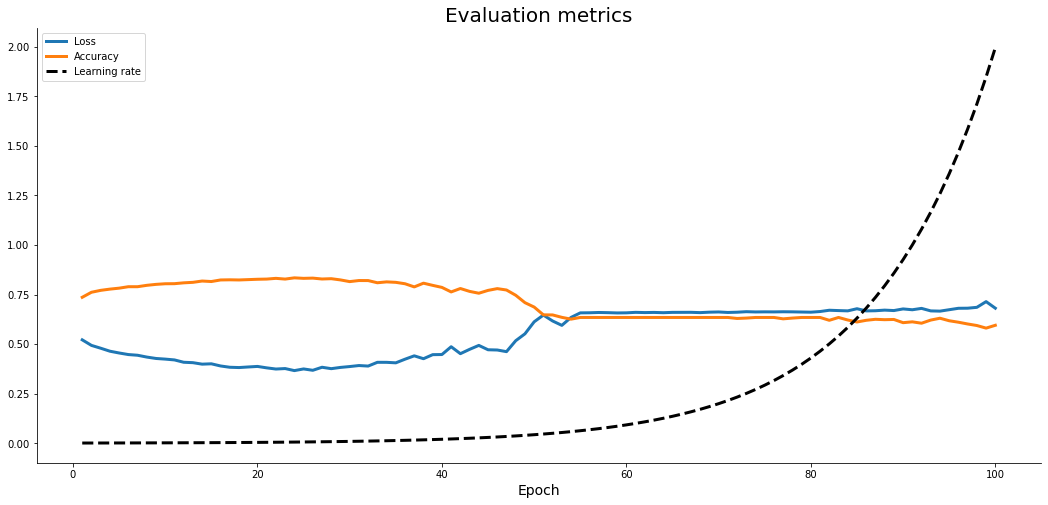

In [21]:
plt.plot(np.arange(1, 101), initial_history.history['loss'], label='Loss', lw=3)
plt.plot(np.arange(1, 101), initial_history.history['accuracy'], label='Accuracy', lw=3)
plt.plot(np.arange(1, 101), initial_history.history['lr'], label='Learning rate', color='#000', lw=3, linestyle='--')
plt.title('Evaluation metrics', size=20)
plt.xlabel('Epoch', size=14)
plt.legend()
plt.savefig('eval_vs_lr.jpg', dpi=300, bbox_inches='tight');

- Accuracy dipped significantly around epoch 50, then flattened, and dipped once again towards the end
- The exact opposite happened to loss
- Let's now plot the learning rate against loss:

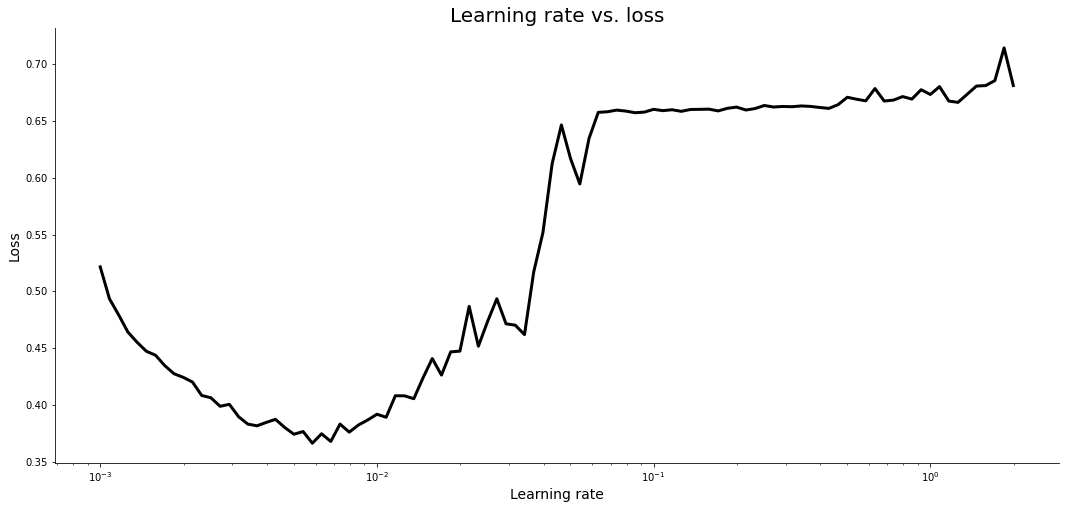

In [25]:
learning_rates = 1e-3 * (10 ** (np.arange(100) / 30))
plt.semilogx(learning_rates, initial_history.history['loss'], lw=3, color='#000')
plt.title('Learning rate vs. loss', size=20)
plt.xlabel('Learning rate', size=14)
plt.ylabel('Loss', size=14)
plt.savefig('lr_vs_loss.jpg', dpi=300, bbox_inches='tight');

<br>

# Training a model with the optimal learning rate
- You're looking for a learning rate value that achieved minimum loss
- Looks like 0.007 works the best for this dataset
- Let's retrain the model:

In [26]:
model_optimized = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_optimized.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.007),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy')
    ]
)

history_optimized = model_optimized.fit(
    X_train_scaled,
    y_train,
    epochs=100
)

Epoch 1/100
162/162 [==============================] - 1s 5ms/step - loss: 0.5336 - accuracy: 0.7412
Epoch 2/100
162/162 [==============================] - 1s 5ms/step - loss: 0.5084 - accuracy: 0.7565
Epoch 3/100
162/162 [==============================] - 1s 5ms/step - loss: 0.5006 - accuracy: 0.7636
Epoch 4/100
162/162 [==============================] - 1s 5ms/step - loss: 0.4867 - accuracy: 0.7700
Epoch 5/100
162/162 [==============================] - 1s 5ms/step - loss: 0.4807 - accuracy: 0.7710
Epoch 6/100
162/162 [==============================] - 1s 5ms/step - loss: 0.4736 - accuracy: 0.7783
Epoch 7/100
162/162 [==============================] - 1s 5ms/step - loss: 0.4738 - accuracy: 0.7737
Epoch 8/100
162/162 [==============================] - 1s 5ms/step - loss: 0.4617 - accuracy: 0.7868
Epoch 9/100
162/162 [==============================] - 1s 5ms/step - loss: 0.4571 - accuracy: 0.7892
Epoch 10/100
162/162 [==============================] - 1s 5ms/step - loss: 0.4512 - accura

- Susipiciously high training accuracy - possible overfit
- Let's plot loss vs. accuracy:

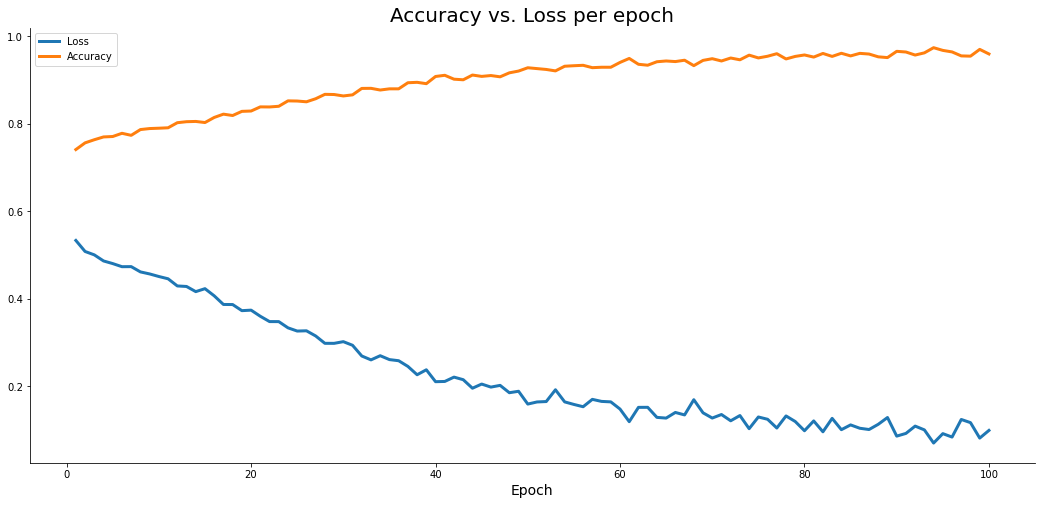

In [28]:
plt.plot(np.arange(1, 101), history_optimized.history['loss'], label='Loss', lw=3)
plt.plot(np.arange(1, 101), history_optimized.history['accuracy'], label='Accuracy', lw=3)
plt.title('Accuracy vs. Loss per epoch', size=20)
plt.xlabel('Epoch', size=14)
plt.legend()
plt.savefig('accuracy_per_epoch.jpg', dpi=300, bbox_inches='tight');

<br>
# Model evaluation on the test set
- Let's now make predictions, convert them to classes and print accuracy and confusion matrix:

In [30]:
predictions = model_optimized.predict(X_test_scaled)
predictions

array([[0.9578252],
       [0.9969375],
       [0.9997428],
       ...,
       [0.9999573],
       [0.660783 ],
       [0.4924225]], dtype=float32)

In [31]:
prediction_classes = [1 if prob > 0.5 else 0 for prob in np.ravel(predictions)]
print(prediction_classes[:20])

[1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1]


In [34]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

print(f'Accuracy on the test set: {accuracy_score(y_test, prediction_classes):.2f}')
print()
print('Confusion matrix:')
print(confusion_matrix(y_test, prediction_classes))

Accuracy on the test set: 0.79

Confusion matrix:
[[348 134]
 [135 676]]


- The accuracy on the test set increased by 3% compared to the default learning rate (0.001) used in the previous notebook